In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

# import my_secrets as sc
# import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE


import pandas as pd

# set-up environment - GEITje-7b-chat InContextLearning:
# - install blobfuse -> sudo apt-get install blobfuse
# - pip install transformers
# - pip install torch
# - pip install accelerate
# - pip install jupyter
# - pip install ipywidgets

### Notebook Overview
Goal: get insight into the predictions made.

In [3]:
txt = pd.read_pickle(f"{cf.output_path}/txtfiles.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/home/azureuser/cloudfiles/code/blobfuse/raadsinformatie/processed_data/woo_document_classification/txtfiles_tokenizer.pkl'

In [5]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../src/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


def get_tokens(model_name, df, text_col, new_col_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    all_texts = list(df[text_col].values)

    all_tokens = []
    all_tokens_len = []
    for txt in all_texts:
        tokens = tokenizer.tokenize(txt)
        all_tokens.append(tokens)
        all_tokens_len.append(len(tokens))

    df[new_col_name] = all_tokens
    df[f"count_{new_col_name}"] = all_tokens_len
    return df

def format_label(label):
    format = f"""{{'categorie': {label}}}"""
    return format
    

def get_response_length(df, model_name):
    # convert response column into tokens, using models tokenizer (so either geitje, mistral or Llama)
    df = get_tokens(model_name, df, 'response', 'responseTokens')

    # convert label into ideal format
    df['label_formatted'] = df['label'].apply(format_label)
    # convert ideal format into tokens, so that we know the ideal length of the responses
    df_ideal = get_tokens(model_name, df.loc[df['run_id']==df.iloc[0]['run_id']], 'label_formatted', 'label_formattedTokens')

    # for each run, describe the response lengths
    description = df.groupby('run_id')['count_responseTokens'].describe()
    description.loc[len(description)] = df_ideal['count_label_formattedTokens'].describe()
    
    print("RESPONSE LENGTH")
    description = description.rename(index={description.index[-1]: 'IDEAL'}).round(1)
    display(description)
    return df
   

def prediction_errors(df):
    print('PREDICTION ERRORS')
    run_ids = sorted(list(set(df['run_id'])))

    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    # only select row that have prediction error -> response of which a prediction could not be extracted. 
    errors_df = df.loc[df['prediction'].isin(error_names)]

    df_errors_count = pd.DataFrame(columns=error_names)

    for runid in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==runid]
        # count for each error the instances
        count = dict(Counter(subdf['prediction']))

        # check if all errors are included, else set that error to 0
        for error in error_names:
            if error not in count.keys():
                count[error]=0

        df_errors_count.loc[len(df_errors_count)] = count

    df_errors_count.index = run_ids
    df_errors_count['total'] = df_errors_count.sum(axis=1)

    print("Count of prediction errors for each run:")
    display(df_errors_count)

    df_classes_in_response_count = pd.DataFrame(columns=['responses with 0 classes', 'responses with 1 classes', 'responses with 2 classes', 'Correct label in response'])

    for run_id in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==run_id]

        classes_in_responses = []
        correct_class_in_response = []
        for index, row in subdf.iterrows():
            # for each response, return list with all labels that are named in response
            classes_in_response = [category.lower() for category in pt.get_class_list() if category.lower() in row['response'].lower()]
            classes_in_responses.append(classes_in_response)

            # for each response, check if true label is named in response.
            if row['label'].lower() in classes_in_response:
                correct_class_in_response.append(True)
            else:
                correct_class_in_response.append(False)

        # count how many classes are named in a response
        amount_of_classes = dict(Counter([len(response) for response in classes_in_responses]))
        amount_of_classes = {f"responses with {k} classes":v for k,v in amount_of_classes.items()}
        amount_of_classes['Correct label in response'] = f"{correct_class_in_response.count(True)} out of {len(subdf)} prediction errors ({round(correct_class_in_response.count(True)/ len(subdf)*100,1)}%)" 
        df_classes_in_response_count.loc[len(df_classes_in_response_count)] = amount_of_classes

        
    df_classes_in_response_count.index = run_ids

    print('amount of class in responses:')
    display(df_classes_in_response_count)

    # for each run count the errors per class
    count_error_class_df_list = []
    for run_id in run_ids:
        # select errors for current runid
        subdf = errors_df.loc[errors_df['run_id']==run_id]
        errors_count_per_class = dict()
        # for each class count the errors
        for category in pt.get_class_list():
            class_df = subdf.loc[subdf['label']==category.lower()]
            count_errors = dict(Counter(class_df['prediction']))
            # sort the errors from highest to lowest for each class
            count_errors = dict(sorted(count_errors.items(), key=lambda item: item[1], reverse=True))
            errors_count_per_class[category] = count_errors

        # create df
        df_errors_count = pd.DataFrame(list(errors_count_per_class.items()), columns=['Class', run_id])
        # add df to list with the dfs of other runs
        count_error_class_df_list.append(df_errors_count)
    
    # combine df into one
    df_errors_count = count_error_class_df_list[0]
    for count_df in count_error_class_df_list[1:]:
        df_errors_count = df_errors_count.merge(count_df, on='Class', how='outer')
    
    pd.set_option('display.max_colwidth', None)
    print('Amount of errors type per class per run:')
    display(df_errors_count)



def evaluation_metrics(df):
    warnings.filterwarnings("ignore", category=UserWarning)
    report = classification_report(df['label'], df['prediction'])
    print('EVALUATION METRICS')
    print(report)


def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')
    run_ids = sorted(list(set(df['run_id'])))

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category.lower() not in class_count.keys():
                class_count[category.lower()] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = run_ids
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = run_ids
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())
   

def runtime(df):
    print("RUNTIME")

    # select all docs that have runtime longer than 75th percentile.
    percentile_75 = df['runtime'].quantile(0.75)

    # count how many docs for each class take longer than 75th percentile
    df_count_long_runtimes = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # calculate average runtime per doc for each class
    df_average_runtime = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # for each run_id, calculate average runtime and count how many docs exceed 75th percentile
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]

        # get very long runtimes
        percentile_75 = subdf['runtime'].quantile(0.75)
        above_75th_percentile = subdf[subdf['runtime'] > percentile_75]
        count_long_runtimes_per_class = dict(Counter(above_75th_percentile['label']))
        df_count_long_runtimes.loc[len(df_count_long_runtimes)] = count_long_runtimes_per_class

        # average runtime per class
        average_runtime_per_class = subdf.groupby('label')['runtime'].mean()
        df_average_runtime.loc[len(df_average_runtime)] = average_runtime_per_class

    df_count_long_runtimes.index = list(set(df['run_id']))
    df_average_runtime.index = list(set(df['run_id']))

    print('Description of runtime per doc:')
    display(df.groupby('run_id')['runtime'].describe().round(1))

    print(f"Amount of docs that took longer than 75th percentile per class:")
    display(df_count_long_runtimes)

    print('Average runtime per doc for each class')
    display(df_average_runtime.transpose().sort_values(by=list(set(df['run_id']))).round(1))


## Truncation Experiment

GEITje - highlights:
- response length quite good, longer because of new lines. Some very long ones though.
- Runtime: on average 5 sec difference, between runs or between classes. Raadsnotulen longest, motie shortest. fastest to slowest: 100, 100/100, 200. 30-ish seconds on average
- Errors: many errors for 100 truncation. Most mistakes are because of no JSON format. Many response do contain the right label. 
- mistakes: onderzoeksrapport (90%, gets mistaken for raadsnotulen) and raadsadressen are very bad. 

Mistral - highlights:
- Response length: the response lengths are quite similar between runs, although 100/100 are on average longer. The runs are much longer than the ideal responses. 
- Runtime per doc: on average the runtimes of 100 and 200 are similar, but the average runtime of 100/100 are a lot longer. Big difference between classes (30-ish sec->130-ish sec), not much between runs. 1min-ish on average.
- Errors per run: quite a difference between amount of errors between runs, but not a big difference between runs of geitje. The errors are more equally divided between the types. By far most responses contain 0 classes. Some response do contain the right label, but much less than geitje responses.
- Mistakes: most mistakes are made in factsheets, brief and actualiteit. Also in onderzoeksrapport (50-ish, mostly mistaken as raadsnotulen or error), but not so dramatic as geitje. Raadsnotulen once again really well. Factsheet get often mistaken as onderzoeksrapporten.

Llama - highlights:
- Response length: compareable between truncation 100 and 200. truncation 100/100 are longer response. The response are way longer than the ideal response (100-ish tokens vs 9-tokens on average)
- Runtime per run: comparable runtime between 100 (128 sec) and 200, though 200 a bit shorter (120sec). 100/100 is quire a bit longer (149sec).  On average, quite a difference between classes (121sec -> 178 for trunc 100/100), but also between runs. 
- Errors: 200 has the most errors, but similar to 100. 100/100 has the least errors. Most errors are NoPredictinInOutput, meaning that the response did include a JSON, but not a class that was in the class list.Most likely the JSON contains made-up classes, as seen in the examples.
- Mistakes: amount of mistakes is quite high for all runs (58/53%). Onderzoeksrapport, raadadres, brief, actualiteit and factsheet have many mistakes (90-ish).


Conclusion:
- response length: GEITje by far response the best in regards to length. keeps them short
- Runtime: geitje by far the shortest, not much difference. 100 and 200 are faster than 100/100 for mistral and llama.
- Errors per run: different problems for models. Geitje does not include JSON format, mistral has some mistakes for all 4, and llama makes up labels.
- Mistakes: geitje most accurate. But performs incredibly bad for onderzoeksrapport, as well as llama. mistral does better better with this but still not great.


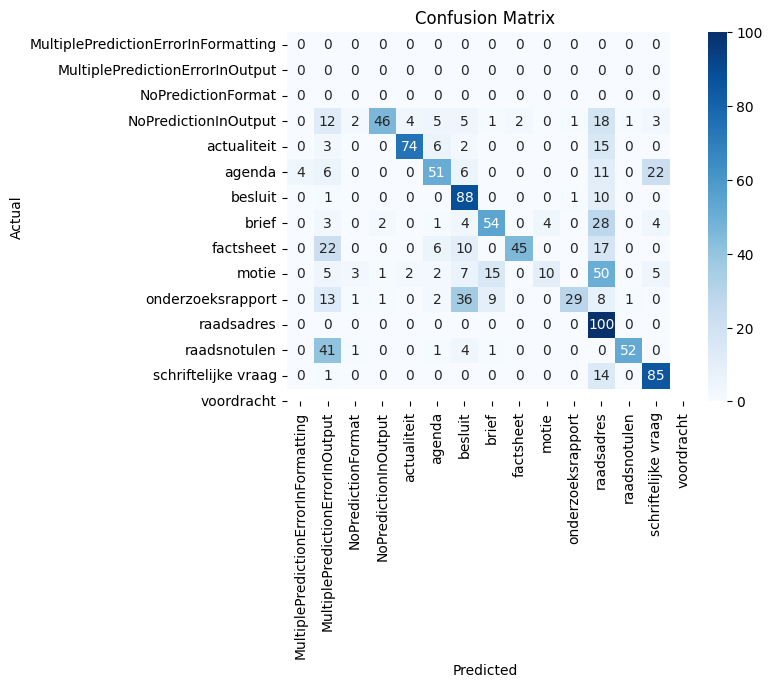

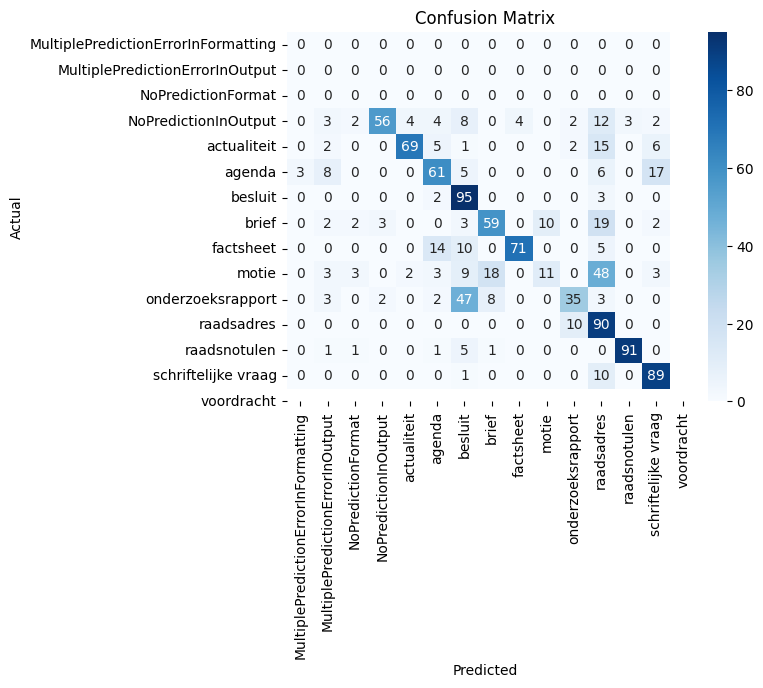

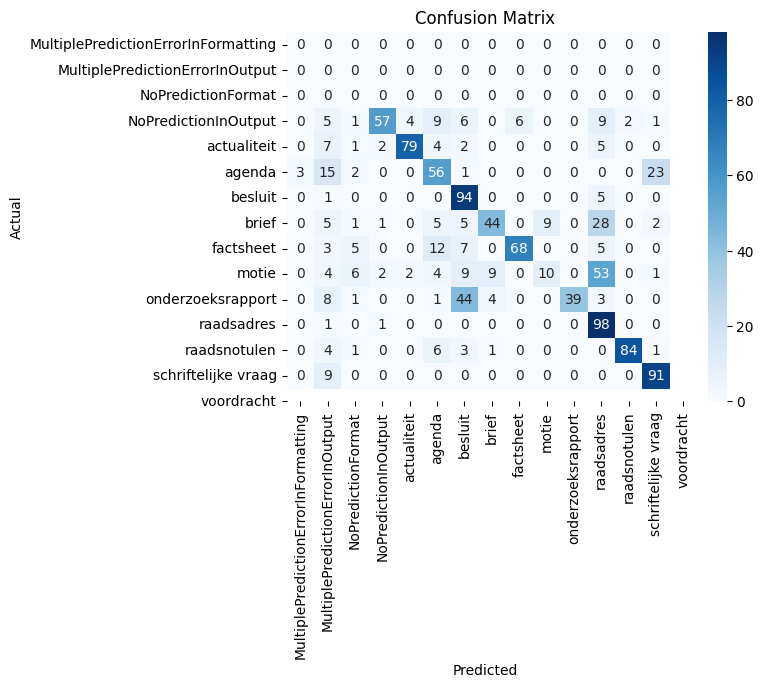

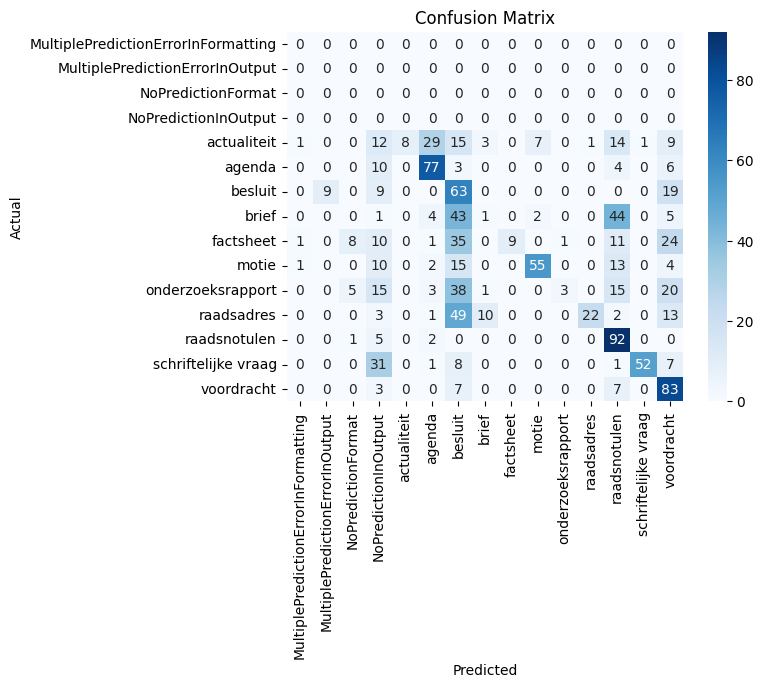

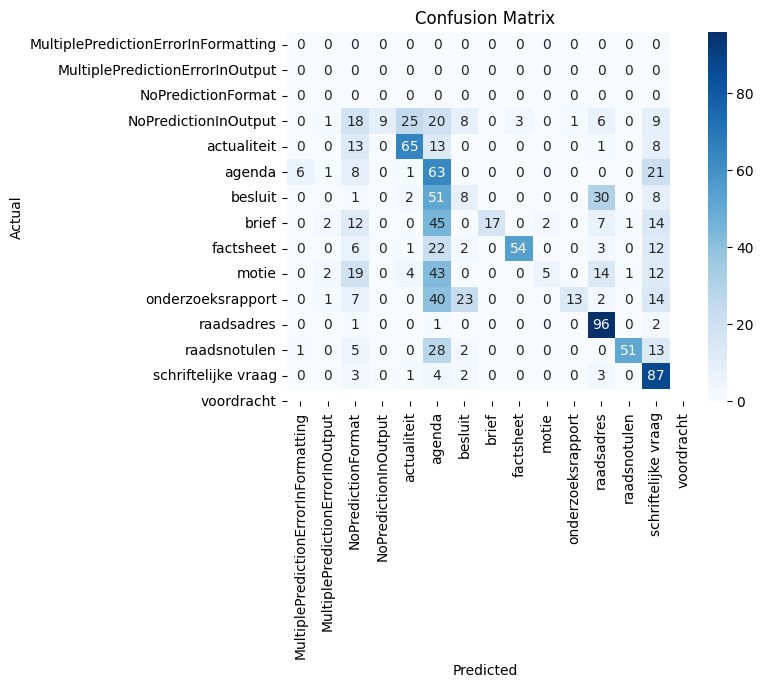

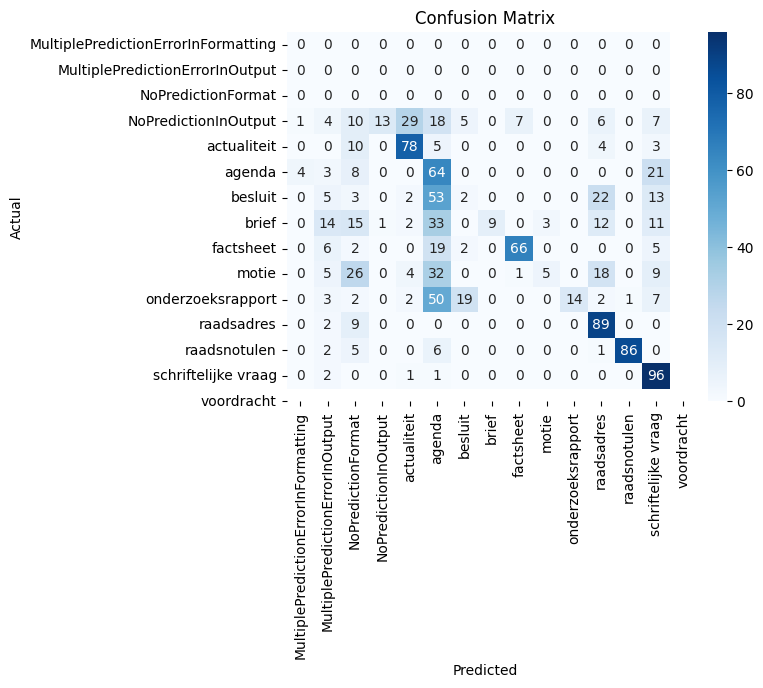

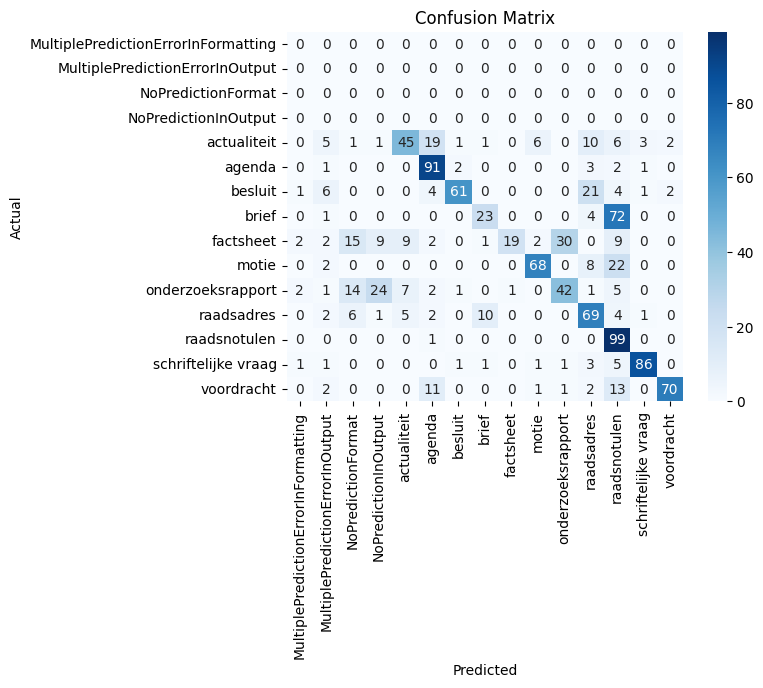

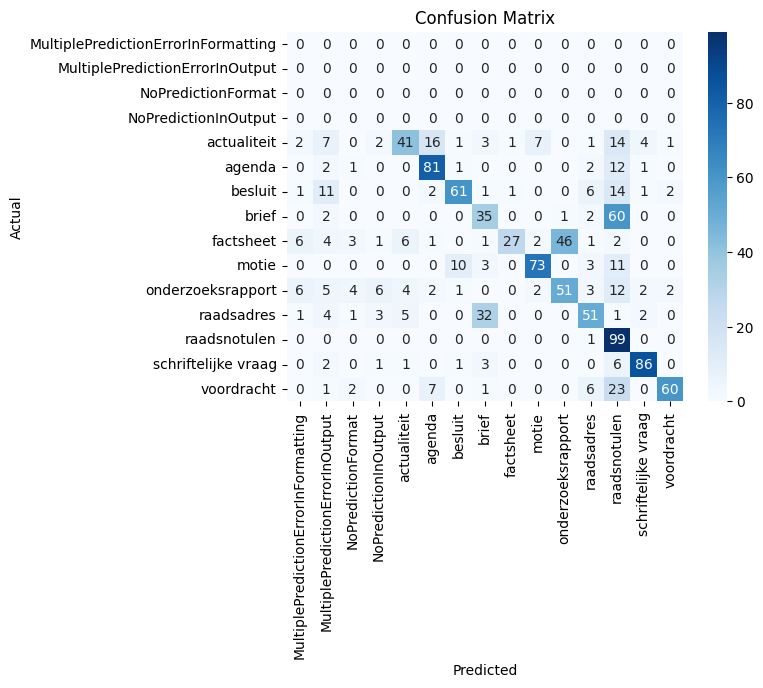

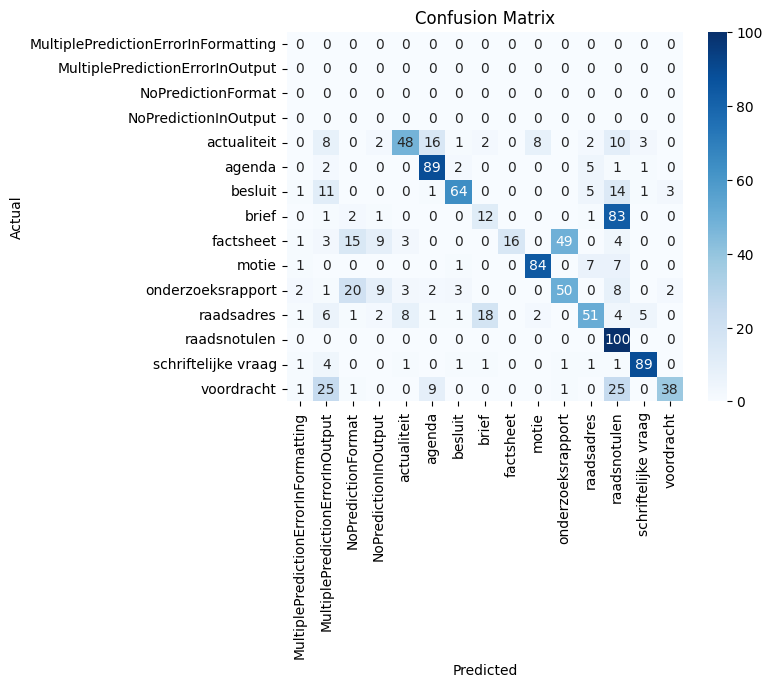

In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def plot_confusion_matrix(df):
    run_ids = sorted(list(set(df['run_id'])))

    class_labels = list(set(df['prediction']))
    label_encoder = LabelEncoder()
    label_encoder.fit(class_labels)

    for run_id in run_ids:
        subdf = df.loc[df['run_id']==run_id]
        y_true_labels = subdf['label']
        y_true = label_encoder.transform(y_true_labels)
        y_pred_labels = subdf['prediction']
        y_pred = label_encoder.transform(y_pred_labels)

        class_names = label_encoder.classes_

        cm = confusion_matrix(y_true, y_pred)


        # Display the confusion matrix using seaborn heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

plot_confusion_matrix(combined)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


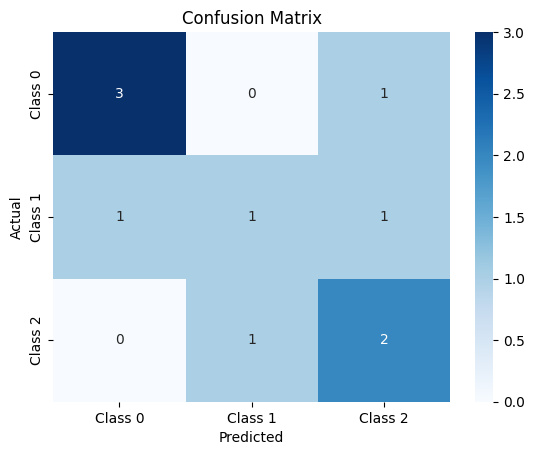

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have lists of true labels and predictions
y_true = [0, 1, 2, 2, 0, 1, 0, 2, 1, 0]  # Example true labels
y_pred = [0, 2, 1, 2, 0, 0, 0, 2, 1, 2]  # Example predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optionally, define class names (if you have them)
class_names = ['Class 0', 'Class 1', 'Class 2']

# Display the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### All models

In [49]:
# truncation experiment
predictions = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First100Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First100Last100Predictions.pkl")

predictions4 = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First100Last0Predictions.pkl")
predictions5 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions6 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First100Last100Predictions.pkl")

predictions7 = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First100Last0Predictions.pkl")
predictions8 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions9 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First100Last100Predictions.pkl")
combined = pd.concat([predictions, predictions2, predictions3, predictions4, predictions5, predictions6, predictions7, predictions8, predictions9])


In [32]:
df_tokenizes_responses = get_response_length(combined,  'meta-llama/Llama-2-7b-chat-hf')


RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,1100.0,15.9,5.6,6.0,15.0,16.0,17.0,127.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,1100.0,16.2,6.6,2.0,15.0,16.0,17.0,223.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,16.1,7.3,3.0,15.0,16.0,17.0,227.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,97.2,50.6,19.0,51.0,86.0,133.2,256.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,109.7,54.4,10.0,55.0,122.0,151.0,256.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,90.2,51.1,11.0,51.0,59.5,132.0,256.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,39.3,46.3,9.0,11.0,12.0,58.0,257.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,44.8,47.1,9.0,11.0,13.0,72.0,256.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,37.7,44.5,9.0,11.0,13.0,58.0,257.0


Response Length:
- Ideal response = 9.1
- 100/100 tends to have on average longer responses. Especially, for Mistral (44.8) and Llama (109.7). Does not really hold for GEITje (16.2)
- 100 and 200 are mostly of similar length, especially for geitje (100=15.9; 200=16.1). Though Llama (100=97.2; 200=90.2) and especially Mistral (100=39.3; 200=37.7) have a difference between them. Just not as big of a difference with 100/100. 
- For GEITje: truncation does not matter for response lenght, minor differences.
- For Mistral: truncation does matter, from smallest to longest response: 200, 100, 100/100. Though the difference not as big for Llama.
- For llama: truncation matters the most for response length: 200,100,100/100. Same order as Mistral.

Conclusion: 200 most ideal response length

In [34]:
runtime(combined)


RUNTIME
Description of runtime per doc:


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,1100.0,29.1,8.4,15.5,26.3,29.2,31.5,204.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,1100.0,30.8,10.4,12.3,28.4,30.0,32.5,358.6
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,32.8,11.7,14.1,30.5,32.5,34.3,375.2
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,127.5,64.4,27.5,70.5,111.9,172.0,353.9
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,149.2,70.9,18.6,77.9,163.2,203.9,363.2
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,120.0,64.8,20.7,69.6,82.5,173.0,356.4
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,63.0,67.2,17.8,21.7,24.6,91.4,378.9
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,74.2,69.8,19.5,24.8,27.9,112.2,408.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,59.8,61.3,18.3,22.5,25.3,88.5,346.9


Amount of docs that took longer than 75th percentile per class:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,33,29,6,56,26,52,NaN,2.0,14,14,43
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,26,34,19,20,15,32,17.0,25.0,24,29,34
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,37,23,26,33,21,16,21.0,18.0,32,24,24
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,47,29,8,29,19,53,1.0,10.0,10,25,44
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,9,11,31,56,10,40,54.0,11.0,13,19,21
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,29,26,22,41,18,55,3.0,NaN,20,16,45
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,6,12,52,49,12,40,60.0,7.0,3,13,21
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,16,14,59,53,6,32,45.0,8.0,7,17,18
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,32,28,14,33,15,25,25.0,21.0,31,19,32


Average runtime per doc for each class


,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0
agenda,24.0,121.1,132.7,50.2,26.9,22.2,30.4,28.9,124.7
raadsnotulen,25.4,116.4,155.7,28.3,31.6,27.9,35.2,33.0,132.2
schriftelijke vraag,34.7,117.3,163.8,41.3,27.7,62.3,34.5,32.5,122.2
actualiteit,39.8,122.9,160.0,69.8,31.2,47.8,35.7,33.6,124.6
motie,44.4,113.3,161.5,42.5,26.4,50.1,30.8,29.4,134.9
raadsadres,63.9,95.2,132.3,68.4,28.9,53.2,30.2,29.0,105.2
besluit,73.9,135.9,157.9,89.8,28.8,64.2,32.4,29.8,130.9
factsheet,83.1,136.7,133.3,107.5,28.1,102.1,31.3,29.4,134.4
voordracht,85.1,125.0,167.9,115.6,29.2,81.2,32.3,30.8,139.0
brief,89.1,101.2,155.2,74.3,31.0,74.5,34.1,31.4,129.6


**Runtime:**
- For GEITje: minor difference in runtime. From shortest to longest runtime: 100 (=29.1sec), 100/100 (=30.8sec), 200 (=32.8sec). 
- For Llama:  Big difference between runtime. From shortest to longest runtime: 200 (=120sec), 100 (=127.5sec), 100/100 (=149.2sec). 
- For Mistral: quite a difference between runtime, more than Geitje, less than Llama. From shortest to longest runtime: 200 (=59.8sec), 100 (=63sec), 100/100 (=74.2sec). 

Difference between 100/100 and other truncation is biggest, 100/100 adds more runtime. 

*Conclusion: 200 most optimal runtime, except for GEITje, adds 3 seconds for each doc compared to optimal option (100).*

**Errors:**
- For GEITje: Big difference in how many errors. From least to most: 100/100 (=33 of which 39% contains correct label), 200(=83 of which 46% contains correct label), 100 (=118 of which 71% contains correct label). For all truncation methods, geitje has the most NoPredictionFormat errors. 
- For Llama: Quite a difference in how many errors, less than GEITje. From least to most: 100/100 (=107 of which 23% contains correct label), 100(=135 of which 16% contains correct label), 200 (=141 of which 22% contains correct label). For all truncation methods, llama has the most NoPredictionInOutput errors. 
- For Mistral: Quite a difference in how many errors, less than GEITje, more than Llama. From least to most: 100/100 (=78 of which 41% contains correct label), 100(=100 of which 23% contains correct label), 200 (=131 of which 34% contains correct label). Does not seem to be a pattern in which prediction error.


*Conclusion: 100/100 best for less errors.*

In [43]:
prediction_errors(combined)


PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,7,0,107,4,118
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,8,0,22,3,33
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,18,0,62,3,83
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,109,3,14,9,135
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,93,0,7,7,107
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,90,0,46,5,141
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,35,6,36,23,100
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,13,16,11,38,78
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,23,8,39,61,131


amount of class in responses:


,responses with 0 classes,responses with 1 classes,responses with 2 classes,Correct label in response
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,9,105,4,84 out of 118 prediction errors (71.2%)
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,8,19,6,13 out of 33 prediction errors (39.4%)
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,20,60,3,38 out of 83 prediction errors (45.8%)
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,70,44,12,22 out of 135 prediction errors (16.3%)
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,58,29,12,23 out of 107 prediction errors (21.5%)
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,63,59,16,33 out of 141 prediction errors (23.4%)
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,57,8,25,23 out of 100 prediction errors (23.0%)
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,17,1,52,32 out of 78 prediction errors (41.0%)
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,45,13,61,44 out of 131 prediction errors (33.6%)


Amount of errors type per class per run:


,Class,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0
0,Actualiteit,"{'NoPredictionFormat': 12, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 3, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}","{'NoPredictionInOutput': 12, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionInOutput': 18, 'NoPredictionFormat': 1}","{'NoPredictionInOutput': 10, 'NoPredictionFormat': 4, 'MultiplePredictionErrorInOutput': 1}","{'MultiplePredictionErrorInOutput': 5, 'NoPredictionInOutput': 1, 'NoPredictionFormat': 1}","{'MultiplePredictionErrorInOutput': 7, 'NoPredictionInOutput': 2, 'MultiplePredictionErrorInFormatting': 2}","{'MultiplePredictionErrorInOutput': 8, 'NoPredictionInOutput': 2}"
1,Agenda,{'NoPredictionFormat': 3},{'NoPredictionFormat': 2},"{'NoPredictionFormat': 7, 'NoPredictionInOutput': 1}",{'NoPredictionInOutput': 10},{'NoPredictionInOutput': 13},{'NoPredictionInOutput': 10},{'MultiplePredictionErrorInOutput': 1},"{'MultiplePredictionErrorInOutput': 2, 'NoPredictionFormat': 1}",{'MultiplePredictionErrorInOutput': 2}
2,Besluit,"{'NoPredictionFormat': 6, 'MultiplePredictionErrorInOutput': 4}","{'NoPredictionFormat': 8, 'MultiplePredictionErrorInOutput': 3}","{'NoPredictionFormat': 15, 'MultiplePredictionErrorInOutput': 3, 'NoPredictionInOutput': 2}","{'NoPredictionInOutput': 9, 'MultiplePredictionErrorInOutput': 9}","{'NoPredictionInOutput': 8, 'MultiplePredictionErrorInOutput': 6, 'NoPredictionFormat': 1}","{'NoPredictionInOutput': 8, 'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 3}","{'MultiplePredictionErrorInOutput': 6, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 11, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 11, 'MultiplePredictionErrorInFormatting': 1}"
3,Brief,{'NoPredictionFormat': 1},{},{'NoPredictionFormat': 1},{'NoPredictionInOutput': 1},{'NoPredictionInOutput': 1},"{'NoPredictionFormat': 5, 'NoPredictionInOutput': 3}",{'MultiplePredictionErrorInOutput': 1},{'MultiplePredictionErrorInOutput': 2},"{'NoPredictionFormat': 2, 'MultiplePredictionErrorInOutput': 1, 'NoPredictionInOutput': 1}"
4,Factsheet,{'NoPredictionFormat': 3},"{'NoPredictionFormat': 2, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}","{'NoPredictionInOutput': 10, 'NoPredictionFormat': 8, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionInOutput': 12, 'NoPredictionFormat': 2}","{'NoPredictionInOutput': 15, 'NoPredictionFormat': 14}","{'NoPredictionFormat': 15, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInFormatting': 2, 'MultiplePredictionErrorInOutput': 2}","{'MultiplePredictionErrorInFormatting': 6, 'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 3, 'NoPredictionInOutput': 1}","{'NoPredictionFormat': 15, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInOutput': 3, 'MultiplePredictionErrorInFormatting': 1}"
5,Motie,{'NoPredictionFormat': 22},{},"{'NoPredictionInOutput': 5, 'NoPredictionFormat': 3}","{'NoPredictionInOutput': 10, 'MultiplePredictionErrorInFormatting': 1}",{'NoPredictionInOutput': 6},"{'NoPredictionFormat': 6, 'NoPredictionInOutput': 2}",{'MultiplePredictionErrorInOutput': 2},{},{'MultiplePredictionErrorInFormatting': 1}
6,Onderzoeksrapport,"{'NoPredictionForm

**Mistakes:**
- For GEITje: Minor difference between 100/100 (33.9%) and 200(34.5%), bigger diffence with 100 (42.4%).
- For Llama: Small difference between 200 (52.5%) and the other truncations (100/100=57.5%; 100=57.7%).
- For Mistral: Small difference between all truncations. From least to most mistakes: 100 (=38.8%), 100/100 (=39.5%), 200 (=41.7%).

*Conclusion: each model different optimal truncation.*

In [44]:
mistakes(combined, False)


MISTAKES. INCLUDES PREDICTIONS ERRORS.
Total amount of mistakes per run:


,run_id,count,percentage of total predictions
0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,466,42.4%
1,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,373,33.9%
2,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,380,34.5%
3,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,635,57.7%
4,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,632,57.5%
5,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,578,52.5%
6,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,427,38.8%
7,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,435,39.5%
8,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,459,41.7%


Amount of mistakes per class for each run:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,15,49,48,12,71,90,0,26,55,54,46
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,11,39,9,5,65,89,10,31,29,44,41
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,9,44,16,6,61,90,2,21,32,43,56
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,17,37,48,99,78,97,8,23,45,92,91
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,13,37,49,92,87,95,4,35,46,91,83
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,4,36,14,98,86,95,11,22,34,87,91
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,30,39,14,77,31,58,1,9,32,55,81
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,40,39,14,65,49,49,1,19,27,59,73
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,62,36,11,88,49,50,0,11,16,52,84


Highest mistakes per class for each run:


,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0
voordracht,raadsnotulen (14 out of 15),raadsnotulen (10 out of 11),NoPredictionFormat (9 out of 9),besluit (7 out of 17),besluit (4 out of 13),NoPredictionFormat (2 out of 4),raadsnotulen (13 out of 30),raadsnotulen (23 out of 40),MultiplePredictionErrorInOutput (25 out of 62)
besluit,voordracht (22 out of 49),voordracht (17 out of 39),voordracht (23 out of 44),voordracht (19 out of 37),voordracht (21 out of 37),voordracht (21 out of 36),raadsadres (21 out of 39),raadsnotulen (14 out of 39),raadsnotulen (14 out of 36)
schriftelijke vraag,NoPredictionFormat (41 out of 48),brief (5 out of 9),besluit (6 out of 16),NoPredictionInOutput (31 out of 48),besluit (28 out of 49),besluit (6 out of 14),raadsnotulen (5 out of 14),raadsnotulen (6 out of 14),MultiplePredictionErrorInOutput (4 out of 11)
brief,raadsnotulen (10 out of 12),raadsnotulen (3 out of 5),raadsnotulen (5 out of 6),raadsnotulen (44 out of 99),besluit (51 out of 92),besluit (53 out of 98),raadsnotulen (72 out of 77),raadsnotulen (60 out of 65),raadsnotulen (83 out of 88)
raadsadres,brief (36 out of 71),brief (47 out of 65),brief (44 out of 61),besluit (49 out of 78),besluit (40 out of 87),besluit (50 out of 86),brief (10 out of 31),brief (32 out of 49),brief (18 out of 49)
onderzoeksrapport,raadsnotulen (50 out of 90),raadsnotulen (48 out of 89),raadsnotulen (53 out of 90),besluit (38 out of 97),besluit (43 out of 95),besluit (32 out of 95),NoPredictionInOutput (24 out of 58),raadsnotulen (12 out of 49),NoPredictionFormat (20 out of 50)
raadsnotulen,NaN,raadsadres (10 out of 10),NoPredictionFormat (1 out of 2),NoPredictionInOutput (5 out of 8),voordracht (2 out of 4),NoPredictionInOutput (9 out of 11),agenda (1 out of 1),raadsadres (1 out of 1),NaN
agenda,raadsnotulen (15 out of 26),raadsnotulen (15 out of 31),NoPredictionFormat (7 out of 21),NoPredictionInOutput (10 out of 23),NoPredictionInOutput (13 out of 35),NoPredictionInOutput (10 out of 22),raadsadres (3 out of 9),raadsnotulen (12 out of 19),raadsadres (5 out of 11)
motie,NoPredictionFormat (22 out of 55),besluit (14 out of 29),besluit (12 out of 32),besluit (15 out of 45),besluit (22 out of 46),besluit (19 out of 34),raadsnotulen (22 out of 32),raadsnotulen (11 out of 27),raadsadres (7 out of 16)
actualiteit,raadsnotulen (18 out of 54),raadsnotulen (12 out of 44),besluit (9 out of 43),agenda (29 out of 92),agenda (25 out of 91),agenda (29 out of 87),agenda (19 out of 55),agenda (16 out of 59),agenda (16 out of 52)


#### GEITje

In [10]:
# truncation experiment
predictions = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First100Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First100Last100Predictions.pkl")
combined = pd.concat([predictions, predictions2, predictions3])


In [11]:
df_tokenizes_responses = get_response_length(combined, 'Rijgersberg/GEITje-7B-chat-v2')

RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,1100.0,16.1,5.8,6.0,14.0,16.0,18.0,136.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,1100.0,16.3,7.0,2.0,14.0,16.0,18.0,236.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,16.2,7.7,4.0,14.0,16.0,18.0,240.0
IDEAL,1100.0,9.3,1.6,7.0,8.0,9.0,11.0,12.0


In [12]:
randomly_selected_rows = df_tokenizes_responses.sample(n=2)
for index, row in randomly_selected_rows.iterrows():
    print(row['count_responseTokens'])
    print(row['response'])

print('\n')
max_response_length_row = df_tokenizes_responses.loc[df_tokenizes_responses['count_responseTokens']==df_tokenizes_responses['count_responseTokens'].max()].iloc[0]
print(max_response_length_row['response'])
print(max_response_length_row['count_responseTokens'])

14
{
    "categorie": "Agenda"
}
19
{
    "categorie": "Raadsinformatiebrief"
}


Technische vragen — actualiteit preventief fouilleren

Voorafgaand aan onderstaande beantwoording wordt opgemerkt dat de vragen zich richten tot
het college, maar dat het aanwijzen van veiligheidsrisicogebieden om wapencontroles te
houden geen collegebevoegdheid betreft. Het betreft een burgemeestersbevoegdheid, die in
afstemming met politie en OM wordt toegepast.

1. Er waren 5 locaties bepaald binnen elk van de vijf aangewezen
veiligheidsrisicogebieden. Ik neem aan dat elke politiebureau vóór aanvang van de
pilot op de hoogte was gebracht over elk van de locatie in zijn of haar eigen
veiligheidsr

    Vul in met de categorie van het document: {'categorie': 'Actualiteit'}     
    
240


Response length: we can see that across the runs the response lengths is pretty consistent, although the truncations 100/100 and 200 tend to go longer, looking at the right tail. However, the 25th to 75th percentile are pretty similar. The runs come quite near to the ideal response length, but they are longer than the ideal response. Looking at the three examples though, we can see that the difference in response length is because of the extra lines, which is not problematic. However, there is a big difference between the runs and the ideal in the right tail. The example of the longest response shows that those response are indeed to longer. Overall response length is quite good.

In [13]:
runtime(combined)

RUNTIME
Description of runtime per doc:


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,1100.0,29.1,8.4,15.5,26.3,29.2,31.5,204.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,1100.0,30.8,10.4,12.3,28.4,30.0,32.5,358.6
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,32.8,11.7,14.1,30.5,32.5,34.3,375.2


Amount of docs that took longer than 75th percentile per class:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,9,11,31,56,10,40,54,11,13,19,21
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,16,14,59,53,6,32,45,8,7,17,18
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,6,12,52,49,12,40,60,7,3,13,21


Average runtime per doc for each class


,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0
motie,26.4,29.4,30.8
agenda,26.9,28.9,30.4
schriftelijke vraag,27.7,32.5,34.5
factsheet,28.1,29.4,31.3
besluit,28.8,29.8,32.4
raadsadres,28.9,29.0,30.2
voordracht,29.2,30.8,32.3
onderzoeksrapport,30.1,30.9,34.3
brief,31.0,31.4,34.1
actualiteit,31.2,33.6,35.7


Average runtime per doc: on average the the runs have quite similar runs times. Although truncation methods 100/100 and 200 have a higher right tail. 

Document per class that take longer than 75th percentile: biggest difference between the runs is for the class schrijftelijk vraag, where truncation 100 has much fewer document than the other truncations above the 75th percentile. Noticable, is that some class have a lot of document in the upper 75th percentile, for example, raadnotulen, brief en schriftelijke vraag.

Average runtime per class: although there are class with significant more documents in the upper 75th percentile, the average between classes is quite similar, max of 5 sec difference on average per doc. Within there is some differences between average runtime per doc of a class, but also not a more than 5 sec difference. Though we should notice that 5 seconds on many documents does grow a lot. 

In [14]:
prediction_errors(combined)

PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,7,0,107,4,118
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,8,0,22,3,33
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,18,0,62,3,83


amount of class in responses:


,responses with 0 classes,responses with 1 classes,responses with 2 classes,Correct label in response
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,9,105,4,84 out of 118 prediction errors
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,8,19,6,13 out of 33 prediction errors
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,20,60,3,38 out of 83 prediction errors


Amount of errors type per class per run:


,Class,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0
0,Actualiteit,"{'NoPredictionFormat': 12, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 3, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}"
1,Agenda,{'NoPredictionFormat': 3},{'NoPredictionFormat': 2},"{'NoPredictionFormat': 7, 'NoPredictionInOutput': 1}"
2,Besluit,"{'NoPredictionFormat': 6, 'MultiplePredictionErrorInOutput': 4}","{'NoPredictionFormat': 8, 'MultiplePredictionErrorInOutput': 3}","{'NoPredictionFormat': 15, 'MultiplePredictionErrorInOutput': 3, 'NoPredictionInOutput': 2}"
3,Brief,{'NoPredictionFormat': 1},{},{'NoPredictionFormat': 1}
4,Factsheet,{'NoPredictionFormat': 3},"{'NoPredictionFormat': 2, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}"
5,Motie,{'NoPredictionFormat': 22},{},"{'NoPredictionInOutput': 5, 'NoPredictionFormat': 3}"
6,Onderzoeksrapport,"{'NoPredictionFormat': 5, 'NoPredictionInOutput': 3}","{'NoPredictionFormat': 3, 'NoPredictionInOutput': 3}","{'NoPredictionInOutput': 6, 'NoPredictionFormat': 4}"
7,Raadsadres,"{'NoPredictionFormat': 13, 'NoPredictionInOutput': 1}",{'NoPredictionFormat': 3},"{'NoPredictionFormat': 8, 'NoPredictionInOutput': 1}"
8,Raadsnotulen,{},{},{'NoPredictionFormat': 1}
9,Schriftelijke Vraag,"{'NoPredictionFormat': 41, 'NoPredictionInOutput': 1}","{'NoPredictionInOutput': 1, 'NoPredictionFormat': 1}","{'NoPredictionFormat': 4, 'NoPredictionInOutput': 1}"


Total errors per run: there's a very big difference in errors between runs. truncation 100 has by var the most, almost four times the amount as 100/100. truncation 200 is also quite bad. It's noticeable that there are no MultiplePredictionErrorInFormatting. Most errors are made because no JSON format is given in the response. 

Classes per response: most responses do contain one class, which we were not able to extract because it probably was not given in JSON format. Additionally, quite many response do contain the right label, although we did not check whether those response contain a second class or not. More than half of the responses for truncation 100 contain the right class but were not extracted, meaning that much improvement can be made.


In [15]:
mistakes(combined, False)


MISTAKES. INCLUDES PREDICTIONS ERRORS.
Total amount of mistakes per run:


,run_id,count,percentage of total predictions
0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,466,42.4%
1,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,373,33.9%
2,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,380,34.5%


Amount of mistakes per class for each run:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,15,49,48,12,71,90,0,26,55,54,46
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,11,39,9,5,65,89,10,31,29,44,41
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,9,44,16,6,61,90,2,21,32,43,56


Highest mistakes per class for each run:


,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_0traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens100_100traintest_numEx0,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0
voordracht,raadsnotulen (14 out of 15),raadsnotulen (10 out of 11),NoPredictionFormat (9 out of 9)
besluit,voordracht (22 out of 49),voordracht (17 out of 39),voordracht (23 out of 44)
schriftelijke vraag,NoPredictionFormat (41 out of 48),brief (5 out of 9),besluit (6 out of 16)
brief,raadsnotulen (10 out of 12),raadsnotulen (3 out of 5),raadsnotulen (5 out of 6)
raadsadres,brief (36 out of 71),brief (47 out of 65),brief (44 out of 61)
onderzoeksrapport,raadsnotulen (50 out of 90),raadsnotulen (48 out of 89),raadsnotulen (53 out of 90)
raadsnotulen,NaN,raadsadres (10 out of 10),NoPredictionFormat (1 out of 2)
agenda,raadsnotulen (15 out of 26),raadsnotulen (15 out of 31),NoPredictionFormat (7 out of 21)
motie,NoPredictionFormat (22 out of 55),besluit (14 out of 29),besluit (12 out of 32)
actualiteit,raadsnotulen (18 out of 54),raadsnotulen (12 out of 44),besluit (9 out of 43)


In [16]:
# onderzoek = combined.loc[(combined['label']=='raadsadres') & (combined['label'])!=combined['prediction']]
# onderzoek = onderzoek.sample(n=10)
# for index, row in onderzoek.iterrows():
#     print(row['prediction'])
#     print(row['prompt'])
# print(len(onderzoek))
# # display(onderzoek)

Mistakes per class: the onderzoeksrapport class does horribly, 90% of the documents for all three runs are wrong predicted, either mistakes or errors. Onderzoeksrapporten get mostly mistaken as raadsnotulen (50 out of 90 mistakes). Looking at the documents, we cna see that the beginnings of those docs are messy and have very different topics, which explains the bad classification. 
Raadsadressen are also quite bad and mostly get mistaken as Brief. Looking at those docs, that seems not that weird.

### Mistral

In [17]:
# truncation experiment
predictions = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First100Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First100Last100Predictions.pkl")
combined = pd.concat([predictions, predictions2, predictions3])


In [18]:
df_tokenizes_responses = get_response_length(combined, 'mistralai/Mistral-7B-Instruct-v0.2')


RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,39.8,46.5,9.0,11.0,13.0,59.2,256.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,45.5,47.5,9.0,11.0,13.0,73.0,256.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,38.0,44.6,9.0,11.0,13.0,59.0,256.0
IDEAL,1100.0,9.3,1.6,7.0,8.0,9.0,11.0,12.0


In [19]:
randomly_selected_rows = df_tokenizes_responses.sample(n=2)
for index, row in randomly_selected_rows.iterrows():
    print(row['count_responseTokens'])
    print(row['response'])

print('\n')
max_response_length_row = df_tokenizes_responses.loc[df_tokenizes_responses['count_responseTokens']==df_tokenizes_responses['count_responseTokens'].max()].iloc[0]
print(max_response_length_row['response'])
print(max_response_length_row['count_responseTokens'])


57
Based on the given text, it is not possible to categorize the document as it does not contain any meaningful content. The text appears to be a random sequence of letters and numbers. Therefore, the output will be an empty JSON file:

{'categorie': ''}
98
{"categorie": "Raadsnotulen"}

Explanation:
The document appears to be a note or memo addressed to the members of the Amsterdam city council regarding a specific topic, in this case, the spreading opening hours of InHolland and the Montessori Scholengemeenschap on Zeeburgereiland. This type of document is commonly referred to as "Raadsnotulen" in Dutch local government context.


Based on the provided document, it can be categorized as a "Besluit" (Decision) or an "Onderzoeksrapport" (Research Report) depending on the content. However, without further context or information about the document's contents, it is difficult to determine with certainty. Here are brief explanations of each category:

* "Voordracht": A speech or presentati

Response length: the response lengths are quite similar between runs, although 100/100 are on average longer. The runs are much longer than the ideal responses. 

In [20]:
runtime(combined)


RUNTIME
Description of runtime per doc:


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,63.0,67.2,17.8,21.7,24.6,91.4,378.9
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,74.2,69.8,19.5,24.8,27.9,112.2,408.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,59.8,61.3,18.3,22.5,25.3,88.5,346.9


Amount of docs that took longer than 75th percentile per class:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,33,29,6,56,26,52,NaN,2.0,14,14,43
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,47,29,8,29,19,53,1.0,10.0,10,25,44
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,29,26,22,41,18,55,3.0,NaN,20,16,45


Average runtime per doc for each class


,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0
agenda,24.0,50.2,22.2
raadsnotulen,25.4,28.3,27.9
schriftelijke vraag,34.7,41.3,62.3
actualiteit,39.8,69.8,47.8
motie,44.4,42.5,50.1
raadsadres,63.9,68.4,53.2
besluit,73.9,89.8,64.2
factsheet,83.1,107.5,102.1
voordracht,85.1,115.6,81.2
brief,89.1,74.3,74.5


Runtime per doc: on average the runtimes of 100 and 200 are similar, but the average runtime of 100/100 are a lot longer. 

Average per doc fo each class: There are very big difference in runtime between classes. raadsnotulen is by far the shortest and onderzoeksrapporten the longest. 

In [21]:
prediction_errors(combined)


PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,23,8,39,61,131
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,13,16,11,38,78
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,35,6,36,23,100


amount of class in responses:


,responses with 0 classes,responses with 1 classes,responses with 2 classes,Correct label in response
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,45,13,61,44 out of 131 prediction errors
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,17,1,52,32 out of 78 prediction errors
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,57,8,25,23 out of 100 prediction errors


Amount of errors type per class per run:


,Class,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0
0,Actualiteit,"{'MultiplePredictionErrorInOutput': 8, 'NoPredictionInOutput': 2}","{'MultiplePredictionErrorInOutput': 7, 'NoPredictionInOutput': 2, 'MultiplePredictionErrorInFormatting': 2}","{'MultiplePredictionErrorInOutput': 5, 'NoPredictionInOutput': 1, 'NoPredictionFormat': 1}"
1,Agenda,{'MultiplePredictionErrorInOutput': 2},"{'MultiplePredictionErrorInOutput': 2, 'NoPredictionFormat': 1}",{'MultiplePredictionErrorInOutput': 1}
2,Besluit,"{'MultiplePredictionErrorInOutput': 11, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 11, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 6, 'MultiplePredictionErrorInFormatting': 1}"
3,Brief,"{'NoPredictionFormat': 2, 'MultiplePredictionErrorInOutput': 1, 'NoPredictionInOutput': 1}",{'MultiplePredictionErrorInOutput': 2},{'MultiplePredictionErrorInOutput': 1}
4,Factsheet,"{'NoPredictionFormat': 15, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInOutput': 3, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInFormatting': 6, 'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 3, 'NoPredictionInOutput': 1}","{'NoPredictionFormat': 15, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInFormatting': 2, 'MultiplePredictionErrorInOutput': 2}"
5,Motie,{'MultiplePredictionErrorInFormatting': 1},{},{'MultiplePredictionErrorInOutput': 2}
6,Onderzoeksrapport,"{'NoPredictionFormat': 20, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInFormatting': 2, 'MultiplePredictionErrorInOutput': 1}","{'MultiplePredictionErrorInFormatting': 6, 'NoPredictionInOutput': 6, 'MultiplePredictionErrorInOutput': 5, 'NoPredictionFormat': 4}","{'NoPredictionInOutput': 24, 'NoPredictionFormat': 14, 'MultiplePredictionErrorInFormatting': 2, 'MultiplePredictionErrorInOutput': 1}"
7,Raadsadres,"{'MultiplePredictionErrorInOutput': 6, 'NoPredictionInOutput': 2, 'NoPredictionFormat': 1, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 4, 'NoPredictionInOutput': 3, 'NoPredictionFormat': 1, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionFormat': 6, 'MultiplePredictionErrorInOutput': 2, 'NoPredictionInOutput': 1}"
8,Raadsnotulen,{},{},{}
9,Schriftelijke Vraag,"{'MultiplePredictionErrorInOutput': 4, 'MultiplePredictionErrorInFormatting': 1}","{'MultiplePredictionErrorInOutput': 2, 'NoPredictionInOutput': 1}","{'MultiplePredictionErrorInOutput': 1, 'MultiplePredictionErrorInFormatting': 1}"


Errors per run: quite a difference between amount of errors between runs, but not a big difference between runs of geitje. The errors are more equally divided between the types. 

Labels in responses: by far most responses contain 0 classes. Some response do contain the right label, but much less than geitje responses.

In [22]:
mistakes(combined, False)


MISTAKES. INCLUDES PREDICTIONS ERRORS.
Total amount of mistakes per run:


,run_id,count,percentage of total predictions
0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,427,38.8%
1,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,435,39.5%
2,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,459,41.7%


Amount of mistakes per class for each run:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,30,39,14,77,31,58,1,9,32,55,81
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,40,39,14,65,49,49,1,19,27,59,73
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,62,36,11,88,49,50,0,11,16,52,84


Highest mistakes per class for each run:


,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0
voordracht,raadsnotulen (13 out of 30),raadsnotulen (23 out of 40),MultiplePredictionErrorInOutput (25 out of 62)
besluit,raadsadres (21 out of 39),raadsnotulen (14 out of 39),raadsnotulen (14 out of 36)
schriftelijke vraag,raadsnotulen (5 out of 14),raadsnotulen (6 out of 14),MultiplePredictionErrorInOutput (4 out of 11)
brief,raadsnotulen (72 out of 77),raadsnotulen (60 out of 65),raadsnotulen (83 out of 88)
raadsadres,brief (10 out of 31),brief (32 out of 49),brief (18 out of 49)
onderzoeksrapport,NoPredictionInOutput (24 out of 58),raadsnotulen (12 out of 49),NoPredictionFormat (20 out of 50)
raadsnotulen,agenda (1 out of 1),raadsadres (1 out of 1),NaN
agenda,raadsadres (3 out of 9),raadsnotulen (12 out of 19),raadsadres (5 out of 11)
motie,raadsnotulen (22 out of 32),raadsnotulen (11 out of 27),raadsadres (7 out of 16)
actualiteit,agenda (19 out of 55),agenda (16 out of 59),agenda (16 out of 52)


Mistakes: most mistakes are made in factsheets, brief and actualiteit. Also in onderzoeksrapport (50-ish, mostly mistaken as raadsnotulen or error), but not so dramatic as geitje. Raadsnotulen once again really well. Factsheet get often mistaken as onderzoeksrapporten.

### Llama

In [23]:
# truncation experiment
predictions = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First100Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First100Last100Predictions.pkl")
combined = pd.concat([predictions, predictions2, predictions3])


In [24]:
df_tokenizes_responses = get_response_length(combined, 'meta-llama/Llama-2-7b-chat-hf')


RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,97.2,50.6,19.0,51.0,86.0,133.2,256.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,109.7,54.4,10.0,55.0,122.0,151.0,256.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,90.2,51.1,11.0,51.0,59.5,132.0,256.0
IDEAL,1100.0,9.1,1.4,7.0,8.0,9.0,10.0,12.0


In [25]:
randomly_selected_rows = df_tokenizes_responses.sample(n=2)
for index, row in randomly_selected_rows.iterrows():
    print(row['count_responseTokens'])
    print(row['response'])

print('\n')
max_response_length_row = df_tokenizes_responses.loc[df_tokenizes_responses['count_responseTokens']==df_tokenizes_responses['count_responseTokens'].max()].iloc[0]
print(max_response_length_row['response'])
print(max_response_length_row['count_responseTokens'])


160
 Based on the content of the document, I would classify it under the category of 'Besluit'.

The document outlines three options for realizing Social Return, which are:

1. Regular placements of candidates belonging to the SR-doelgroep on work
2. Social Inkopen
3. Social Return projects

It also mentions the possibility of exemptions from the selection criteria and provides information on the assessment and appointment of candidates.

Therefore, the document can be classified as a decision or policy document that outlines the options and procedures for implementing Social Return in Amsterdam.

Here is the output in JSON format:

{
"categorie": "Besluit"
}
106
 Based on the content of the document you provided, the category that best fits it is:

{'categorie': 'Agenda'}

This document appears to be an agenda for a meeting of the Raadscommissie MIDDELEN, which is a municipal committee in the city of Amsterdam. The document outlines the items to be discussed during the meeting, includ

Response length: compareable between truncation 100 and 200. truncation 100/100 are longer response. The response are way longer than the ideal response (100-ish tokens vs 9-tokens on average)

In [26]:
runtime(combined)


RUNTIME
Description of runtime per doc:


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,1100.0,127.5,64.4,27.5,70.5,111.9,172.0,353.9
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,1100.0,149.2,70.9,18.6,77.9,163.2,203.9,363.2
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,120.0,64.8,20.7,69.6,82.5,173.0,356.4


Amount of docs that took longer than 75th percentile per class:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,37,23,26,33,21,16,21,18,32,24,24
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,26,34,19,20,15,32,17,25,24,29,34
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,32,28,14,33,15,25,25,21,31,19,32


Average runtime per doc for each class


,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0
onderzoeksrapport,121.2,135.3,124.5
raadsadres,132.3,95.2,105.2
agenda,132.7,121.1,124.7
factsheet,133.3,136.7,134.4
brief,155.2,101.2,129.6
raadsnotulen,155.7,116.4,132.2
besluit,157.9,135.9,130.9
actualiteit,160.0,122.9,124.6
motie,161.5,113.3,134.9
schriftelijke vraag,163.8,117.3,122.2


Runtime per run: comparable runtime between 100 (128 sec) and 200, though 200 a bit shorter (120sec). 100/100 is quire a bit longer (149sec).  On average, quite a difference between classes (121sec -> 178 for trunc 100/100), but also between runs. 

In [27]:
prediction_errors(combined)


PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,93,0,7,7,107
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,90,0,46,5,141
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,109,3,14,9,135


amount of class in responses:


,responses with 0 classes,responses with 1 classes,responses with 2 classes,Correct label in response
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,58,29,12,23 out of 107 prediction errors
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,63,59,16,33 out of 141 prediction errors
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,70,44,12,22 out of 135 prediction errors


Amount of errors type per class per run:


,Class,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0
0,Actualiteit,"{'NoPredictionInOutput': 18, 'NoPredictionFormat': 1}","{'NoPredictionInOutput': 10, 'NoPredictionFormat': 4, 'MultiplePredictionErrorInOutput': 1}","{'NoPredictionInOutput': 12, 'MultiplePredictionErrorInFormatting': 1}"
1,Agenda,{'NoPredictionInOutput': 13},{'NoPredictionInOutput': 10},{'NoPredictionInOutput': 10}
2,Besluit,"{'NoPredictionInOutput': 8, 'MultiplePredictionErrorInOutput': 6, 'NoPredictionFormat': 1}","{'NoPredictionInOutput': 8, 'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 3}","{'NoPredictionInOutput': 9, 'MultiplePredictionErrorInOutput': 9}"
3,Brief,{'NoPredictionInOutput': 1},"{'NoPredictionFormat': 5, 'NoPredictionInOutput': 3}",{'NoPredictionInOutput': 1}
4,Factsheet,"{'NoPredictionInOutput': 12, 'NoPredictionFormat': 2}","{'NoPredictionInOutput': 15, 'NoPredictionFormat': 14}","{'NoPredictionInOutput': 10, 'NoPredictionFormat': 8, 'MultiplePredictionErrorInFormatting': 1}"
5,Motie,{'NoPredictionInOutput': 6},"{'NoPredictionFormat': 6, 'NoPredictionInOutput': 2}","{'NoPredictionInOutput': 10, 'MultiplePredictionErrorInFormatting': 1}"
6,Onderzoeksrapport,"{'NoPredictionInOutput': 19, 'NoPredictionFormat': 2}","{'NoPredictionInOutput': 26, 'NoPredictionFormat': 5}","{'NoPredictionInOutput': 15, 'NoPredictionFormat': 5}"
7,Raadsadres,"{'NoPredictionInOutput': 7, 'NoPredictionFormat': 1}","{'NoPredictionFormat': 3, 'NoPredictionInOutput': 2}",{'NoPredictionInOutput': 3}
8,Raadsnotulen,{'NoPredictionInOutput': 1},"{'NoPredictionInOutput': 9, 'NoPredictionFormat': 2}","{'NoPredictionInOutput': 5, 'NoPredictionFormat': 1}"
9,Schriftelijke Vraag,"{'NoPredictionInOutput': 5, 'MultiplePredictionErrorInOutput': 1}","{'NoPredictionInOutput': 5, 'NoPredictionFormat': 2}",{'NoPredictionInOutput': 31}


In [28]:
error = combined.loc[combined['prediction'] == 'NoPredictionInOutput'].sample(n=2)
for index, row in error.iterrows():
    print(row['response'])

 Based on the provided information, I would classify the document as:

{'categorie': 'Schriftelijke Vragen'}

This document appears to be a response to a series of written questions submitted by a member of the Gemeente Amsterdam council, Shahsavari-Jansen, on April 5, 2016. The document provides answers to the questions in a formal and structured manner, indicating that it falls under the category of 'Schriftelijke Vragen'.
 Based on the content of the document provided, I would classify it under the category of "Onderzoek en Statistiek (O&S) monitor".

Here is the output in the form of a JSON file:

{
"categorie": "Onderzoek en Statistiek (O&S) monitor"
}

Explanation:

The document is related to the monitoring of education paths of students in vocational secondary education (mbo) in Amsterdam, which falls under the category of "Onderzoek en Statistiek (O&S)". The document mentions various locations in Amsterdam, including ROC van Amsterdam, ROC TOP, and Mediacollege Amsterdam, which

Errors: 200 has the most errors, but similar to 100. 100/100 has the least errors. Most errors are NoPredictinInOutput, meaning that the response did include a JSON, but not a class that was in the class list.Most likely the JSON contains made-up classes, as seen in the examples.

In [29]:
mistakes(combined, False)


MISTAKES. INCLUDES PREDICTIONS ERRORS.
Total amount of mistakes per run:


,run_id,count,percentage of total predictions
0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,635,57.7%
1,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,632,57.5%
2,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,578,52.5%


Amount of mistakes per class for each run:


,voordracht,besluit,schriftelijke vraag,brief,raadsadres,onderzoeksrapport,raadsnotulen,agenda,motie,actualiteit,factsheet
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,17,37,48,99,78,97,8,23,45,92,91
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,13,37,49,92,87,95,4,35,46,91,83
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,4,36,14,98,86,95,11,22,34,87,91


Highest mistakes per class for each run:


,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_0traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens100_100traintest_numEx0,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0
voordracht,besluit (7 out of 17),besluit (4 out of 13),NoPredictionFormat (2 out of 4)
besluit,voordracht (19 out of 37),voordracht (21 out of 37),voordracht (21 out of 36)
schriftelijke vraag,NoPredictionInOutput (31 out of 48),besluit (28 out of 49),besluit (6 out of 14)
brief,raadsnotulen (44 out of 99),besluit (51 out of 92),besluit (53 out of 98)
raadsadres,besluit (49 out of 78),besluit (40 out of 87),besluit (50 out of 86)
onderzoeksrapport,besluit (38 out of 97),besluit (43 out of 95),besluit (32 out of 95)
raadsnotulen,NoPredictionInOutput (5 out of 8),voordracht (2 out of 4),NoPredictionInOutput (9 out of 11)
agenda,NoPredictionInOutput (10 out of 23),NoPredictionInOutput (13 out of 35),NoPredictionInOutput (10 out of 22)
motie,besluit (15 out of 45),besluit (22 out of 46),besluit (19 out of 34)
actualiteit,agenda (29 out of 92),agenda (25 out of 91),agenda (29 out of 87)


Mistakes: amount of mistakes is quite high for all runs (58/53%). Onderzoeksrapport, raadadres, brief, actualiteit and factsheet have many mistakes (90-ish).